In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# For data preparation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# For Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MaxPool1D, GlobalAvgPool1D, Conv1D, Dropout, BatchNormalization

# for callback
from tensorflow.keras.callbacks import ModelCheckpoint

A travers ce notebook on tente de faire plusieurs techniques d'augmentation des données pour améliorer le résultat trouvé dans le fichier COPD-all-1D-signal

In [2]:
monfichier = pd.read_csv("./capteurs/capteur1.csv")
macolonne = monfichier["class"]
macolonne.to_csv("./capteurs/labels/labels.csv", index=None)

In [8]:
macolonne

0     smoker
1     smoker
2     smoker
3     smoker
4     smoker
       ...  
73       air
74       air
75       air
76       air
77       air
Name: class, Length: 78, dtype: object

In [13]:
def stack_dataset_balanced(path, etiq, test_size=0.3) :
    listefichier = os.listdir(path)
    fv_train = list()
    fv_test = list()
    etiq = etiq.astype('category').cat.codes

    for file in listefichier :
        all_path = os.path.join(path,file)
        if not os.path.isdir(all_path) :
            monfichier = pd.read_csv(all_path)
            monfichier.drop(["class"], axis=1, inplace=True)
            features_train, features_test, etiq_train, etiq_test = train_test_split(monfichier, etiq, test_size=test_size, random_state=42)
            sm = SMOTE(random_state = 2, k_neighbors=3)
            features_train_res, etiq_train_res = sm.fit_sample(features_train, etiq_train.ravel())
            fv_train.append(features_train_res)
            fv_test.append(features_test)
    fv_train = np.dstack(fv_train)
    fv_test = np.dstack(fv_test)
    etiq_train_res = np.expand_dims(etiq_train_res, axis=1)
    etiq_test = np.expand_dims(etiq_test, axis=1)
    return fv_train, fv_test, etiq_train_res, etiq_test

In [14]:
fv_train, fv_test, etiq_train, etiq_test =stack_dataset_balanced("./capteurs", macolonne)
fv_train.shape, fv_test.shape, etiq_train.shape, etiq_test.shape

((112, 4000, 8), (24, 4000, 8), (112, 1), (24, 1))

Epoch 1/42
22/23 [===========================>..] - ETA: 0s - loss: 1.1665 - accuracy: 0.4659
Epoch 1: accuracy improved from -inf to 0.47191, saving model to .\Model_CNN1D_all
INFO:tensorflow:Assets written to: .\Model_CNN1D_all\assets
23/23 [==============================] - 7s 216ms/step - loss: 1.1579 - accuracy: 0.4719 - val_loss: 1.9726 - val_accuracy: 0.0000e+00
Epoch 2/42
22/23 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.6932
Epoch 2: accuracy improved from 0.47191 to 0.68539, saving model to .\Model_CNN1D_all
INFO:tensorflow:Assets written to: .\Model_CNN1D_all\assets
23/23 [==============================] - 6s 255ms/step - loss: 0.6872 - accuracy: 0.6854 - val_loss: 1.6292 - val_accuracy: 0.0000e+00
Epoch 3/42
22/23 [===========================>..] - ETA: 0s - loss: 0.5261 - accuracy: 0.8068
Epoch 3: accuracy improved from 0.68539 to 0.80899, saving model to .\Model_CNN1D_all
INFO:tensorflow:Assets written to: .\Model_CNN1D_all\assets
23/23 [======

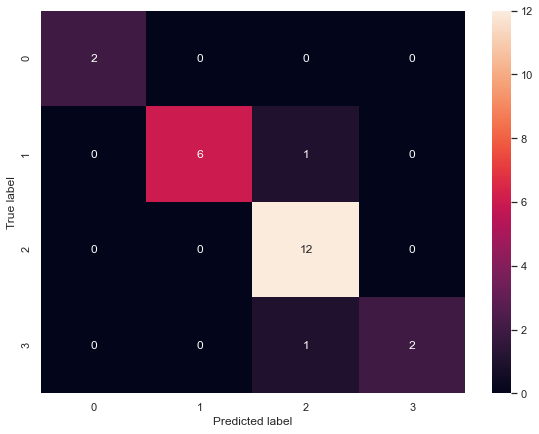

In [21]:
    # CNN Variables
    # Première couche du CNN
filter_size1 = 5
num_filters1 = 64
    # Deuxième couche du CNN 
filter_size2 = 5
num_filters2 = 32

batch_size = 4
num_channels = fv_train.shape[2] # ! paramètre sur lequel on pourrait jouer si on ajoute les autres capteurs
n_epochs = 42
signal = fv_train.shape[1]
    

# CNN
path_to_save_model = './Model_CNN1D_all'

ckpt_saver = ModelCheckpoint(
path_to_save_model,
monitor='accuracy', # sur quoi on se base pour voir le meilleur
mode = 'max', # max de l'accuracy sur la validation
save_best_only = True,
save_freq='epoch', # ne voit qu'à la fin de l'époque
verbose=1) 


model = tf.keras.Sequential(
[
    Input(shape=(signal,num_channels)), # format d'entrée
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size2, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    #BatchNormalization(),
    Conv1D(filters=num_filters1, kernel_size=filter_size1, activation='relu'),
    Conv1D(filters=num_filters2, kernel_size=filter_size1, activation='relu'),
    Dropout(0.5),
    MaxPool1D(pool_size=2),
    #BatchNormalization(),
    GlobalAvgPool1D(),
    Dense(50, activation='relu'),
    Dense(4, activation='softmax')
]
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(fv_train, etiq_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.2, callbacks=[ckpt_saver])

# Evaluation of the model
print("\n\n==================================== Modele evaluation ====================================")
model.evaluate(fv_test,etiq_test, batch_size=batch_size)
print("===========================================================================================\n\n")
y_model=model.predict(fv_test)
y_model_max = np.argmax(y_model, axis=1)
con_mat = tf.math.confusion_matrix(labels=etiq_test, predictions=y_model_max).numpy()

# Visualization
sns.set_theme(style='darkgrid')
plt.figure(figsize=(8, 6))
sns.heatmap(con_mat, annot=True)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

On voit qu'avec le SMOTE on n'améliore pas les résultats et donc on va opter pour une autre méthode (on pourrait essayer d'appliquer le SMOTE sur les autres manière d'aborder le projet)